In [74]:
import pandas as pd
import numpy as np
import operator
from matplotlib import pyplot as plt
from collections import Counter
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

In [2]:
orders=pd.read_csv('orders.csv')
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [3]:
order_products__prior=pd.read_csv('order_products__prior.csv')
order_products__prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [4]:
products=pd.read_csv('products.csv')
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [5]:
department_df=pd.read_csv('departments.csv')
department_df

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [6]:
department_df.values

array([[1, 'frozen'],
       [2, 'other'],
       [3, 'bakery'],
       [4, 'produce'],
       [5, 'alcohol'],
       [6, 'international'],
       [7, 'beverages'],
       [8, 'pets'],
       [9, 'dry goods pasta'],
       [10, 'bulk'],
       [11, 'personal care'],
       [12, 'meat seafood'],
       [13, 'pantry'],
       [14, 'breakfast'],
       [15, 'canned goods'],
       [16, 'dairy eggs'],
       [17, 'household'],
       [18, 'babies'],
       [19, 'snacks'],
       [20, 'deli'],
       [21, 'missing']], dtype=object)

In [7]:
department_xref=sorted(department_df.values.tolist())
department_xref
print(dir(department_xref))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [8]:
for item in department_xref:
    print(item[0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [9]:
department_xref={k[0]:k[1] for k in department_xref}
department_xref

{1: 'frozen',
 2: 'other',
 3: 'bakery',
 4: 'produce',
 5: 'alcohol',
 6: 'international',
 7: 'beverages',
 8: 'pets',
 9: 'dry goods pasta',
 10: 'bulk',
 11: 'personal care',
 12: 'meat seafood',
 13: 'pantry',
 14: 'breakfast',
 15: 'canned goods',
 16: 'dairy eggs',
 17: 'household',
 18: 'babies',
 19: 'snacks',
 20: 'deli',
 21: 'missing'}

In [10]:
department_df['department'].unique()

array(['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international',
       'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care',
       'meat seafood', 'pantry', 'breakfast', 'canned goods',
       'dairy eggs', 'household', 'babies', 'snacks', 'deli', 'missing'],
      dtype=object)

In [11]:
department_xref

{1: 'frozen',
 2: 'other',
 3: 'bakery',
 4: 'produce',
 5: 'alcohol',
 6: 'international',
 7: 'beverages',
 8: 'pets',
 9: 'dry goods pasta',
 10: 'bulk',
 11: 'personal care',
 12: 'meat seafood',
 13: 'pantry',
 14: 'breakfast',
 15: 'canned goods',
 16: 'dairy eggs',
 17: 'household',
 18: 'babies',
 19: 'snacks',
 20: 'deli',
 21: 'missing'}

In [12]:
len(order_products__prior['product_id'].unique())

49677

In [13]:
customer_prd = pd.merge(orders, order_products__prior, on='order_id', how='inner')

In [14]:
customer_prd

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


In [15]:
item_total= customer_prd.groupby(['product_id', 'user_id'])[['order_id']].count()
item_total.columns=['total']

In [16]:
# customer_prd.groupby(['product_id', 'user_id'])[['order_id']].count().reset_index(name='item_total')
# customer_prd
customer_prd['item_count'] = customer_prd.groupby(['product_id', 'user_id'])[['order_id']].transform('count')


In [17]:



customer_prd.user_id.unique()

array([     1,      2,      3, ..., 206207, 206208, 206209])

In [18]:
customer_1=customer_prd[(customer_prd['user_id']==1)&(customer_prd['product_id']==196)]
customer_1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,item_count
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
5,2398795,1,prior,2,3,7,15.0,196,1,1,10
11,473747,1,prior,3,3,12,21.0,196,1,1,10
16,2254736,1,prior,4,4,7,29.0,196,1,1,10
21,431534,1,prior,5,4,15,28.0,196,1,1,10
29,3367565,1,prior,6,2,7,19.0,196,1,1,10
33,550135,1,prior,7,1,9,20.0,196,1,1,10
39,3108588,1,prior,8,1,14,14.0,196,2,1,10
47,2295261,1,prior,9,1,16,0.0,196,4,1,10
50,2550362,1,prior,10,4,8,30.0,196,1,1,10


In [19]:
customer_1.drop_duplicates( 'product_id' , keep='first')
customer_1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,item_count
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
5,2398795,1,prior,2,3,7,15.0,196,1,1,10
11,473747,1,prior,3,3,12,21.0,196,1,1,10
16,2254736,1,prior,4,4,7,29.0,196,1,1,10
21,431534,1,prior,5,4,15,28.0,196,1,1,10
29,3367565,1,prior,6,2,7,19.0,196,1,1,10
33,550135,1,prior,7,1,9,20.0,196,1,1,10
39,3108588,1,prior,8,1,14,14.0,196,2,1,10
47,2295261,1,prior,9,1,16,0.0,196,4,1,10
50,2550362,1,prior,10,4,8,30.0,196,1,1,10


In [20]:
customer_1=customer_prd[customer_prd['user_id']==1][['product_id','item_count']]
customer_1

,product_id,item_count
0,196,10
1,14084,1
2,12427,10
3,26088,2
4,26405,2
5,196,10
6,10258,9
7,12427,10
8,13176,2
9,26088,2


In [21]:
customer_1=customer_1.drop_duplicates(['product_id','item_count'],keep= 'last').sort_values('item_count',ascending=False)
customer_list=customer_1[:5]

# customer_list.index = np.arange(1, len(customer_list) + 1)

In [22]:
customer_cart=customer_prd[['user_id','product_id','item_count']].drop_duplicates(['user_id','product_id','item_count'],keep= 'last').sort_values(['user_id','item_count'],ascending=False)
customer_cart[customer_cart['user_id']==1][:5]['product_id']
print(type(customer_cart[customer_cart['user_id']==1][:5]['product_id']))
customer_cart
# customer_cart_dct=dict()
# for customer in customer_cart['user_id'].unique():
#     customer_cart_dct[customer]=pd.to_list(customer_cart[customer_cart['user_id'==customer]][:5]['product_id'])
# print(customer_cart_dct)
customer_cart.sort_values('user_id')
a=customer_cart[customer_cart['user_id']==1][['product_id']].iloc[0]
print(a)

<class 'pandas.core.series.Series'>
product_id    196
Name: 50, dtype: int64


In [23]:
print(type(len(customer_prd['user_id'].unique())))
num=len(customer_prd['user_id'].unique())

<class 'int'>


In [24]:
customer_prd.groupby(['user_id','product_id'])[['order_id']].count()

order_id
user_id product_id          
1       196               10
        10258              9
        10326              1
        12427             10
        13032              3
...                      ...
206209  43961              3
        44325              1
        48370              1
        48697              1
        48742              2

[13307953 rows x 1 columns]

In [29]:
customer_cart=customer_prd[['user_id','product_id','item_count']].drop_duplicates(['user_id','product_id','item_count'],keep= 'last').sort_values(['user_id','item_count'],ascending=False)
customer_sample=customer_cart.iloc[:200]
customer_sample
# len(customer_sample['user_id'].unique())


,user_id,product_id,item_count
32434460,206209,6846,10
32434481,206209,9405,9
32434464,206209,41213,7
32434431,206209,13176,6
32434463,206209,19348,4
...,...,...,...
32433897,206208,25447,1
32433908,206208,43129,1
32433909,206208,16083,1
32433921,206208,16490,1


No handles with labels found to put in legend.


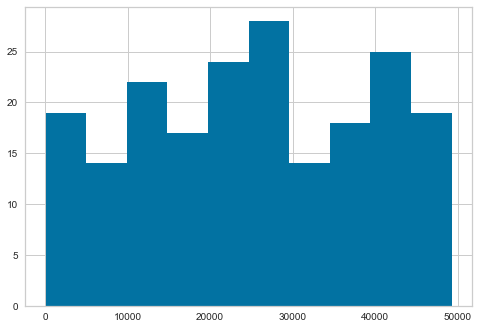

In [30]:
fig,ax=plt.subplots()
ax.hist(customer_sample['product_id'],bins=10)
ax.legend()
plt.show()


In [31]:
sample_matrix=np.zeros((len(customer_sample['user_id'].unique()),6))

sample_matrix=np.asarray(sample_matrix, dtype = int)
sample_matrix
# sample_matrix[:,0]=np.astype(int)
sample_matrix[:,0]=customer_sample['user_id'].unique()
sample_matrix

array([[206209,      0,      0,      0,      0,      0],
       [206208,      0,      0,      0,      0,      0]])

In [32]:
customer_sample[customer_sample['user_id']==206209]

,user_id,product_id,item_count
32434460,206209,6846,10
32434481,206209,9405,9
32434464,206209,41213,7
32434431,206209,13176,6
32434463,206209,19348,4
...,...,...,...
32434483,206209,39216,1
32434485,206209,38730,1
32434486,206209,31477,1
32434487,206209,6567,1


In [33]:
most_common_cart=customer_cart.sort_values(['user_id','item_count'],ascending = False).groupby('user_id').head(5)
most_common_cart


,user_id,product_id,item_count
32434460,206209,6846,10
32434481,206209,9405,9
32434464,206209,41213,7
32434431,206209,13176,6
32434463,206209,19348,4
...,...,...,...
50,1,196,10
58,1,12427,10
55,1,10258,9
54,1,25133,8


In [34]:
most_common_product=pd.merge(most_common_cart, products, on='product_id', how='inner')
most_common_product
most_common_product=most_common_product.sort_values(['user_id','item_count'],ascending = False)
most_common_product

,user_id,product_id,item_count,product_name,aisle_id,department_id
0,206209,6846,10,Diet Pepsi Pack,77,7
197,206209,9405,9,Calcium Enriched 100% Lactose Free Fat Free Milk,91,16
400,206209,41213,7,French Loaf,112,3
500,206209,13176,6,Bag of Organic Bananas,24,4
24060,206209,19348,4,Fat Free Milk,84,16
...,...,...,...,...,...,...
212365,1,12427,10,Original Beef Jerky,23,19
308678,1,196,10,Soda,77,7
664127,1,10258,9,Pistachios,117,19
656042,1,25133,8,Organic String Cheese,21,16


In [35]:
most_common_product.groupby(['aisle_id'])[['aisle_id']].count()

,aisle_id
aisle_id,
1,2601
2,1905
3,11158
4,3973
5,668
...,...
130,2783
131,3658
132,96


In [36]:
# df[['STNAME','CTYNAME']].groupby(['STNAME'])['CTYNAME'].count().nlargest(5)

In [37]:
product_count=most_common_product.groupby(['department_id','product_name'])['product_name'].count().nlargest(200).reset_index(name='top5')
product_count

,department_id,product_name,top5
0,4,Banana,32900
1,4,Bag of Organic Bananas,23560
2,4,Organic Baby Spinach,12499
3,4,Organic Strawberries,10866
4,4,Organic Avocado,10420
...,...,...,...
195,15,Organic Black Beans,675
196,7,Coconut Water,674
197,16,Fresh CA Grown Eggs,670
198,16,Organic Heavy Whipping Cream,669


In [38]:
product_count=most_common_product.groupby(['department_id','product_name']).agg({'item_count':sum})
product_count
g = product_count['item_count'].groupby('department_id', group_keys=False)
res = g.apply(lambda x: x.sort_values(ascending=False).head(5))
print(dir(res))

['T', '_AXIS_LEN', '_AXIS_NAMES', '_AXIS_NUMBERS', '_AXIS_ORDERS', '_AXIS_REVERSED', '_AXIS_TO_AXIS_NUMBER', '_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__divmod__', '__doc__', '__eq__', '__finalize__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__rdivmod__', '__

### Data Visualization

In [39]:
department_1=res.loc[1,:]
department_1=department_1.transpose()

# print(dir(department_1))
department_1.index
print(type(department_1))
department_1

<class 'pandas.core.series.Series'>


department_id  product_name                     
1              Blueberries                          11900
               Organic Broccoli Florets              6763
               Macaroni & Cheese                     5760
               Organic Whole Strawberries            5656
               Chicken & Maple Breakfast Sausage     4988
Name: item_count, dtype: int64

In [40]:
print(dir(res))

['T', '_AXIS_LEN', '_AXIS_NAMES', '_AXIS_NUMBERS', '_AXIS_ORDERS', '_AXIS_REVERSED', '_AXIS_TO_AXIS_NUMBER', '_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__divmod__', '__doc__', '__eq__', '__finalize__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__rdivmod__', '__

In [41]:
res.get(key=1)

product_name
Blueberries                          11900
Organic Broccoli Florets              6763
Macaroni & Cheese                     5760
Organic Whole Strawberries            5656
Chicken & Maple Breakfast Sausage     4988
Name: item_count, dtype: int64

In [42]:
department_1[1]['Blueberries']

11900

In [43]:
department_1[1].values

array([11900,  6763,  5760,  5656,  4988])

In [44]:
list(department_1[1].index)

['Blueberries',
 'Organic Broccoli Florets',
 'Macaroni & Cheese',
 'Organic Whole Strawberries',
 'Chicken & Maple Breakfast Sausage']

In [45]:
# colors = {'fruit':'red', 'veggie':'green'}         
# labels = list(colors.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.legend(handles, labels)

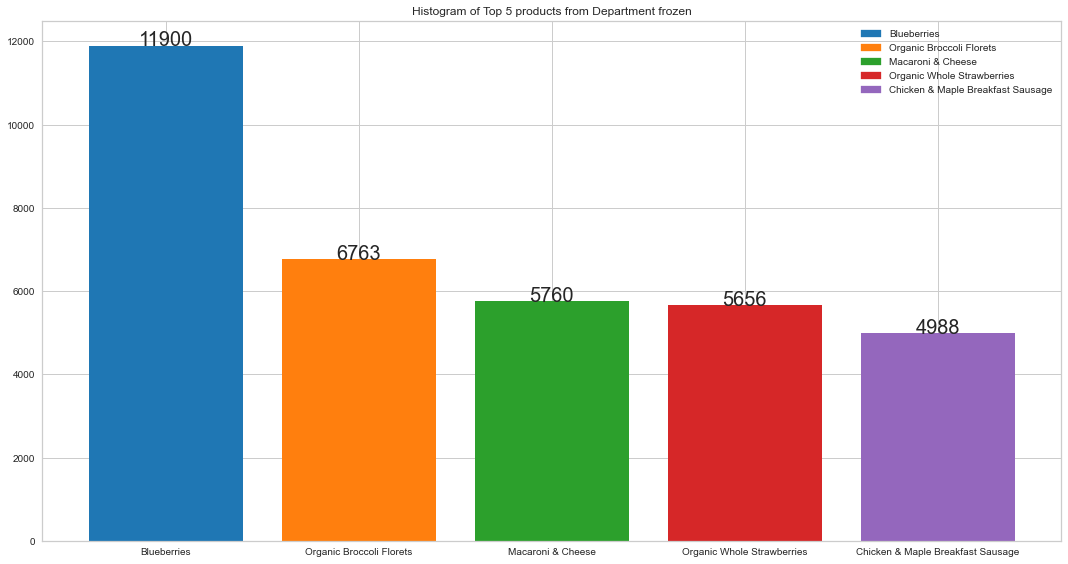

In [46]:

fig,ax=plt.subplots(1,figsize=(15,8))
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
     '#bcbd22', '#17becf']
labels=list(department_1[1].index)
ax.grid(zorder=3)
ax.bar(department_1[1].index,department_1[1].values,color=c,label=list(department_1[1].index))
# ax.title(f'Histogram of Top 5 products from {department_xref[1]}')
for index,data in enumerate(department_1[1].values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20),horizontalalignment='center')
handles = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx,ele in enumerate(c)]
plt.title(f'Histogram of Top 5 products from Department {department_xref[1]}')
plt.legend(handles,labels)
plt.tight_layout()
plt.savefig('../image/frozen_histogram.png',dpi=200)

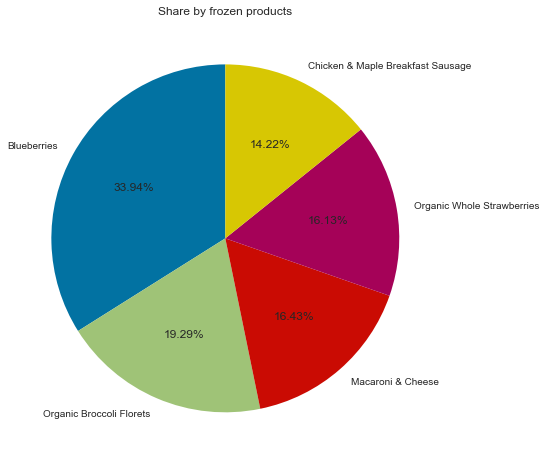

In [47]:
fig,ax=plt.subplots(1,figsize=(12,8))
plt.pie(department_1[1].values, labels = department_1[1].index, startangle = 90,autopct='%1.2f%%')
plt.title(f'Share by {department_xref[1]} products')
# plt.show() 
plt.savefig('../image/frozen_pie.png',dpi=200)

In [48]:
print(type(res))

<class 'pandas.core.series.Series'>


In [49]:
print(dir(res))

['T', '_AXIS_LEN', '_AXIS_NAMES', '_AXIS_NUMBERS', '_AXIS_ORDERS', '_AXIS_REVERSED', '_AXIS_TO_AXIS_NUMBER', '_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__divmod__', '__doc__', '__eq__', '__finalize__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__rdivmod__', '__

In [50]:
res.index

MultiIndex([( 1,                                           'Blueberries'),
            ( 1,                              'Organic Broccoli Florets'),
            ( 1,                                     'Macaroni & Cheese'),
            ( 1,                            'Organic Whole Strawberries'),
            ( 1,                     'Chicken & Maple Breakfast Sausage'),
            ( 2,                                 'Roasted Almond Butter'),
            ( 2,            'Coffee Mate French Vanilla Creamer Packets'),
            ( 2,               'Light CocoWhip! Coconut Whipped Topping'),
            ( 2,                                      '93/7 Ground Beef'),
            ( 2,                                       'Pinot Noir Rose'),
            ...
            (20,                                       'Original Hummus'),
            (20,                                  'Uncured Genoa Salami'),
            (20,                               'Organic Extra Firm Tofu'),
         

In [51]:
dir(res.index.names)

['__add__',
 '__annotations__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__delslice__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__req__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__setslice__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessors',
 '_constructor',
 '_deprecations',
 '_dir_additions',
 '_dir_deletions',
 '_disabled',
 '_reset_cache',
 'append',
 'clear',
 'copy',
 'count',
 'difference',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort',
 'union']

In [52]:
for element in res.index.names:
    print(element)

department_id
product_name


In [53]:
res.index.names[0]

'department_id'

In [54]:
most_common_product[res.index.names[0]].unique()

array([ 7, 16,  3,  4, 20, 19,  1, 12,  9, 13, 15,  8, 14,  6, 18, 11, 17,
        5, 10, 21,  2])

In [55]:
# Department 2
department_2=res.loc[2,:]
department_2=department_2.transpose()
department_2

department_id  product_name                              
2              Roasted Almond Butter                         1122
               Coffee Mate French Vanilla Creamer Packets     382
               Light CocoWhip! Coconut Whipped Topping        311
               93/7 Ground Beef                               261
               Pinot Noir Rose                                204
Name: item_count, dtype: int64

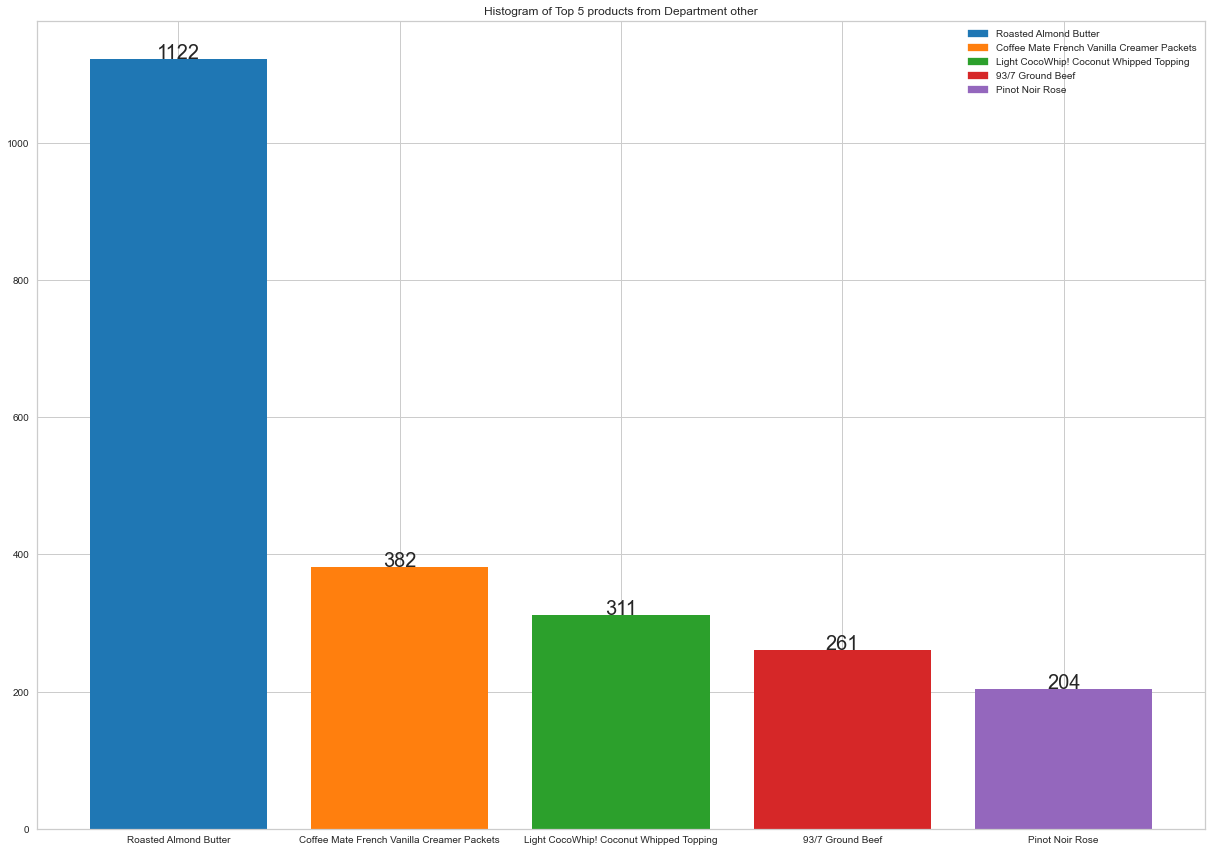

In [56]:
fig,ax=plt.subplots(1,figsize=(17,12))
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
     '#bcbd22', '#17becf']
labels=list(department_2[2].index)
ax.grid(zorder=3)
ax.bar(department_2[2].index,department_2[2].values,color=c,label=list(department_2[2].index))
# ax.title(f'Histogram of Top 5 products from {department_xref[1]}')
for index,data in enumerate(department_2[2].values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20),horizontalalignment='center')
handles = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx,ele in enumerate(c)]
plt.title(f'Histogram of Top 5 products from Department {department_xref[2]}')
plt.legend(handles,labels)
plt.tight_layout()
plt.savefig('../image/other_histogram.png',dpi=200)

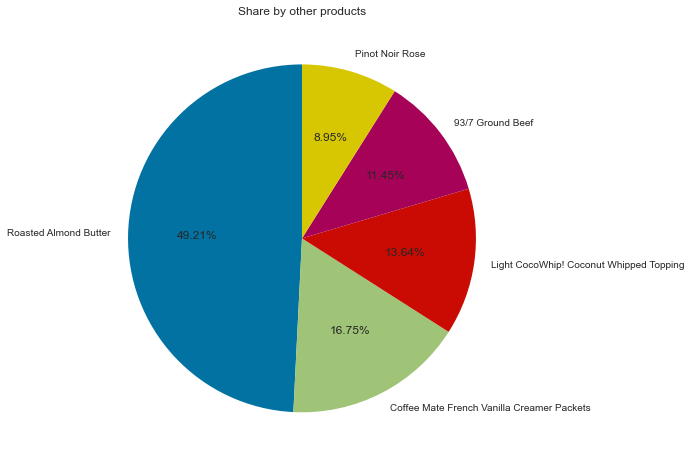

In [57]:
fig,ax=plt.subplots(1,figsize=(12,8))
plt.pie(department_2[2].values, labels = department_2[2].index, startangle = 90,autopct='%1.2f%%')
plt.title(f'Share by {department_xref[2]} products')
# plt.show() 
plt.savefig('../image/other_pie.png')

In [58]:
department_3=res.loc[3,:]
department_3=department_3.transpose()
department_3

department_id  product_name                             
3              100% Whole Wheat Bread                       23957
               Organic Bread with 21 Whole Grains            6078
               Sourdough Bread                               5910
               Organic Honey Sweet Whole Wheat Bread         5653
               Original Nooks & Crannies English Muffins     4284
Name: item_count, dtype: int64

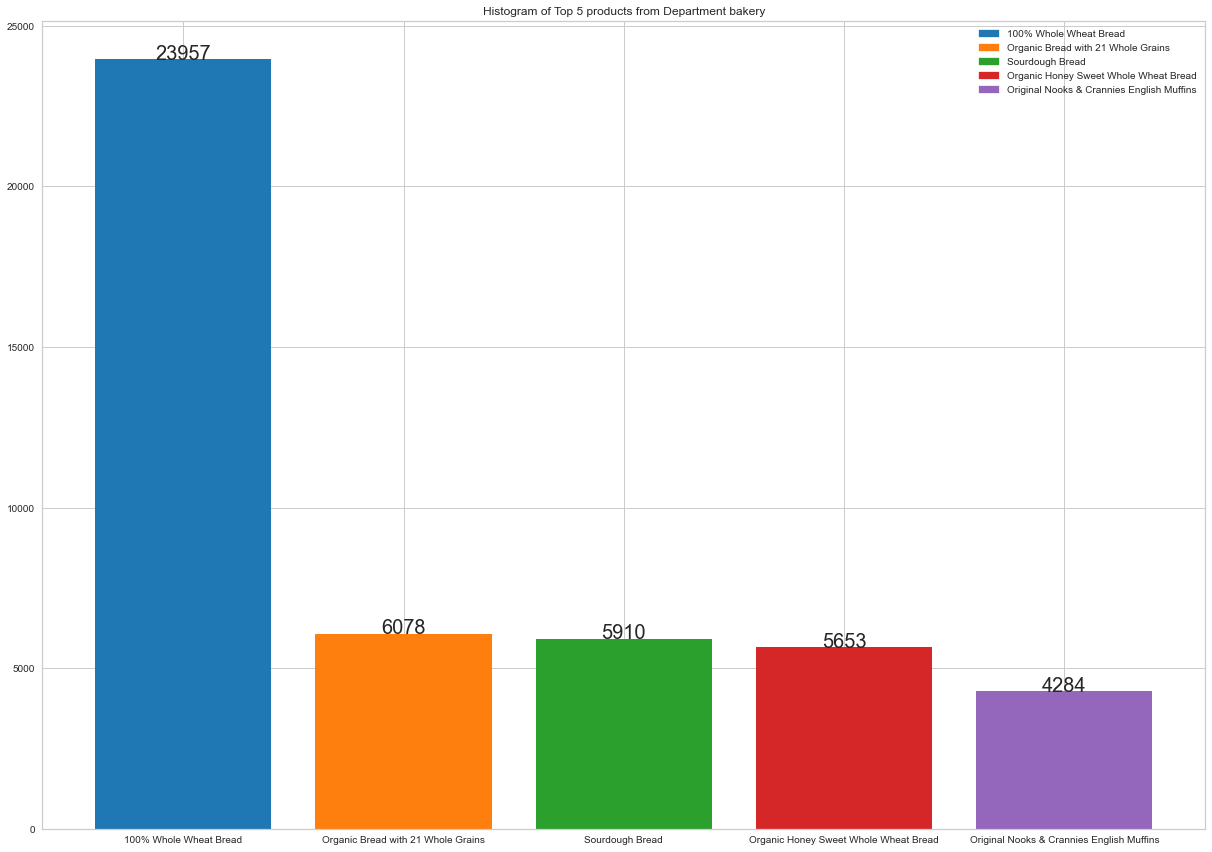

In [59]:
fig,ax=plt.subplots(1,figsize=(17,12))
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
     '#bcbd22', '#17becf']
labels=list(department_3[3].index)
ax.grid(zorder=3)
ax.bar(department_3[3].index,department_3[3].values,color=c,label=list(department_3[3].index))
# ax.title(f'Histogram of Top 5 products from {department_xref[1]}')
for index,data in enumerate(department_3[3].values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20),horizontalalignment='center')
handles = [plt.Rectangle((0,0),1,1, color=c[idx]) for idx,ele in enumerate(c)]
plt.title(f'Histogram of Top 5 products from Department {department_xref[3]}')
plt.legend(handles,labels)
plt.tight_layout()
plt.savefig('../image/bakery_histogram.png')

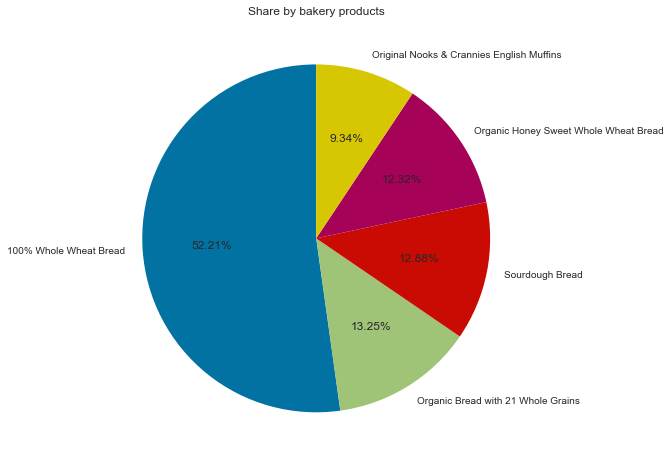

In [60]:
fig,ax=plt.subplots(1,figsize=(12,8))
plt.pie(department_3[3].values, labels = department_3[3].index, startangle = 90,autopct='%1.2f%%')
plt.title(f'Share by {department_xref[3]} products')
plt.savefig('../image/bakery_pie.png')
# plt.show() 

In [61]:
# res.loc[1,:]
# # print(dir(res.loc[1,:]))

In [62]:
department_2=res.loc[2,:]
department_2.unstack()

product_name,Roasted Almond Butter,Coffee Mate French Vanilla Creamer Packets,Light CocoWhip! Coconut Whipped Topping,93/7 Ground Beef,Pinot Noir Rose
department_id,,,,,
2,1122,382,311,261,204


In [63]:
customer_cart[customer_cart['product_id']==6846][['item_count']].sum()


item_count    3076
dtype: int64

In [64]:
total_orders= customer_cart.groupby('product_id')['item_count'].cumsum()
total_orders

32434460       10
32434481        9
32434464        7
32434431        6
32434463        4
            ...  
26          13880
27          35413
52           5019
53          13238
56          57895
Name: item_count, Length: 13307953, dtype: int64

In [65]:
product_list=customer_cart['product_id'].unique()
product_sense=pd.DataFrame(product_list,columns=['product_id'])
product_sense


,product_id
0,6846
1,9405
2,41213
3,13176
4,19348
...,...
49672,48461
49673,45400
49674,36998
49675,10806


In [66]:
product_sense

,product_id
0,6846
1,9405
2,41213
3,13176
4,19348
...,...
49672,48461
49673,45400
49674,36998
49675,10806


In [67]:
customer_prd.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'item_count'],
      dtype='object')

In [68]:
X=customer_prd[['user_id','order_hour_of_day','product_id','add_to_cart_order','reordered','item_count']]
y=customer_prd[['reordered']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42, shuffle=True)

# Instantiate an XGBoost object with hyperparameters
xgb_reg = xgb.XGBRegressor(max_depth=3, n_estimators=100, n_jobs=2,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05)

# Train the model with train data sets
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test) # Predictions
y_true = y_test # True values

MSE = mse(y_true, y_pred)
RMSE = np.sqrt(MSE)

R_squared = r2_score(y_true, y_pred)

print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))

# Making the Prediction Error Plot
# print("\nPrediction Error Plot")
# print(prediction_error(xgb_reg, X_train, y_train, X_test, y_test))

# Making the Residuals Plot
# print("\nResiduals Plot")
# print(residuals_plot(xgb_reg, X_train, y_train, X_test, y_test))


[22:32:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { objectvie } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [69]:
sorted(most_common_product[res.index.names[0]].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [70]:
for ele in sorted(most_common_product[res.index.names[0]].unique()):
    department_ele=res.loc[ele,:]
    department_ele=department_ele.transpose()
    department_ele

In [71]:
print(department_ele)

department_id  product_name                                         
21             Organic Riced Cauliflower                                885
               Peanut Butter Ice Cream Cup                              373
               Natural Lemon Flavored Sparkling Water                   290
               Soy & Dairy Free Plain Unsweetened Almond Milk Yogurt    212
               Organic Mango Yogurt                                     195
Name: item_count, dtype: int64


### Hypothesis Testing

In [76]:
orders['eval_set'].unique()

array(['prior', 'train', 'test'], dtype=object)

In [77]:
orders[orders['eval_set']=='test']

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


In [129]:
products.product_id.unique().max()

49688

In [122]:
len(order_products__prior[order_products__prior['product_id']==1])

1852

In [134]:
order_prior=pd.DataFrame(order_products__prior.groupby('product_id')['reordered']\
                     .agg([('number_of_orders',len),('sum_of_reorders',sum)]))
# order_prior.loc['number_of_orders']
order_prior['observed_reorder_probability']=order_prior['sum_of_reorders']/order_prior['number_of_orders']
order_prior['observed_reorder_probability']

dir(order_prior)


['T',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__re

In [145]:
order_prior_product=pd.merge(order_prior,products,on='product_id',how='right')
order_prior_product
# order_prior_product.groupby(['department_id'])['number_of_orders'].count().nlargest(200).reset_index(name='top5')
# order_prior_product.groupby('department_id')['sum_of_reorders'].agg(sum)
order_prior_product['dep_total_order'] =order_prior_product['number_of_orders'].groupby(order_prior_product['department_id']).transform('sum').astype('int')
order_prior_product['dep_total_reorder']=order_prior_product['sum_of_reorders'].groupby(order_prior_product['department_id']).transform('sum').astype('int')

In [147]:
order_prior_product['dep_reorder_probability']=order_prior_product['dep_total_reorder']/order_prior_product['dep_total_order']

In [148]:
order_prior_product

,product_id,number_of_orders,sum_of_reorders,observed_reorder_probability,product_name,aisle_id,department_id,dep_total_order,dep_total_reorder,dep_reorder_probability
0,1,1852.0,1136.0,0.613391,Chocolate Sandwich Cookies,61,19,2887550,1657973,0.574180
1,2,90.0,12.0,0.133333,All-Seasons Salt,104,13,1875577,650301,0.346721
2,3,277.0,203.0,0.732852,Robust Golden Unsweetened Oolong Tea,94,7,2690129,1757892,0.653460
3,4,329.0,147.0,0.446809,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,2236432,1211890,0.541885
4,5,15.0,9.0,0.600000,Green Chile Anytime Sauce,5,13,1875577,650301,0.346721
...,...,...,...,...,...,...,...,...,...,...
49683,49684,9.0,1.0,0.111111,"Vodka, Triple Distilled, Twist of Vanilla",124,5,153696,87595,0.569924
49684,49685,49.0,6.0,0.122449,En Croute Roast Hazelnut Cranberry,42,1,2236432,1211890,0.541885
49685,49686,120.0,84.0,0.700000,Artisan Baguette,112,3,1176787,739188,0.628141
49686,49687,13.0,6.0,0.461538,Smartblend Healthy Metabolism Dry Cat Food,41,8,97724,58760,0.601285
